## PPC

In [1]:
import csv
import gzip
import os
import sys
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import time
import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap
import copy

import scanorama
from sklearn.preprocessing import normalize

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

import hotspot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

sys.path.append("../utils/")
from utils import *

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
%load_ext autoreload
%autoreload 2
%matplotlib inline

overwrite=True

set_seed(0)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='2'

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

In [3]:
# Load anndata
anndataset_111 = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_206 = anndata.read(save_path + "spleen_lymph_206.h5ad")

# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset_111.uns["protein_names"]]
)
keep_pro_206 = np.array(
    [
        not (p.startswith("HTO") or p.startswith("ADT_Isotype"))
        for p in anndataset_206.uns["protein_names"]
    ]
)

anndataset_111.obsm["protein_expression"] = anndataset_111.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset_111.uns["protein_names"] = anndataset_111.uns["protein_names"][keep_pro_111]
anndataset_206.obsm["protein_expression"] = anndataset_206.obsm["protein_expression"][
    :, keep_pro_206
]
anndataset_206.uns["protein_names"] = anndataset_206.uns["protein_names"][keep_pro_206]

# Organize and instantiate scVI dataset
hvg_111 = anndataset_111.var["hvg_encode"]
hvg_206 = anndataset_206.var["hvg_encode"]

assert (hvg_111 == hvg_206).all()

dataset_111 = AnnDatasetFromAnnData(ad=anndataset_111[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset_111.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_111.uns["protein_names"],
)
dataset_111.initialize_cell_measurement(protein_data_111)
dataset_111.gene_names = anndataset_111[:, hvg_111].var_names.values

dataset_206 = AnnDatasetFromAnnData(ad=anndataset_206[:, hvg_111])
protein_data_206 = CellMeasurement(
    name="protein_expression",
    data=anndataset_206.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_206.uns["protein_names"],
)
dataset_206.initialize_cell_measurement(protein_data_206)
dataset_206.gene_names = anndataset_206[:, hvg_206].var_names.values


dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset_111, dataset_206])

[2020-03-04 09:29:59,629] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-04 09:29:59,634] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-04 09:29:59,748] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 09:29:59,861] INFO - scvi.dataset.dataset | Downsampled from 16828 to 16828 cells
[2020-03-04 09:30:00,845] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-04 09:30:00,849] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-04 09:30:00,956] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 09:30:01,063] INFO - scvi.dataset.dataset | Downsampled from 15820 to 15820 cells
[2020-03-04 09:30:01,357] INFO - scvi.dataset.dataset | Keeping 4005 genes
[2020-03-04 09:30:01,604] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 09:30:01,781] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-04 0

In [4]:
def create_dataset(dataset):
    return copy.deepcopy(dataset)

In [5]:
cell_numbers = [1200 * 2 ** i for i in range(5)] + [dataset.nb_cells]
cell_numbers

[1200, 2400, 4800, 9600, 19200, 32648]

In [7]:
if overwrite is True:
    inference_times = []
    train_histories = []
    for n_cells in cell_numbers:
        d = create_dataset(dataset)
        d.subsample_cells(n_cells)

        m = TOTALVI(
            d.nb_genes,
            d.protein_expression.shape[1],
            n_latent=20,
            n_batch=d.n_batches,
        )
        use_cuda = True
        lr = 4e-3
        early_stopping_kwargs = {
            "early_stopping_metric": "elbo",
            "save_best_state_metric": "elbo",
            "patience": 45,
            "threshold": 0,
            "reduce_lr_on_plateau": True,
            "lr_patience": 30,
            "lr_factor": 0.6,
            "posterior_class": TotalPosterior,
        }

        trainer = TotalTrainer(
            m,
            d,
            train_size=0.9,
            test_size=0.1,
            use_cuda=use_cuda,
            frequency=1,
            data_loader_kwargs={"batch_size": 256, "pin_memory":True},
            early_stopping_kwargs=early_stopping_kwargs,
        )

        t0 = time.time()
        trainer.train(n_epochs=500)
        t = time.time() - t0

        inference_times.append(t)
        train_histories.append(trainer.history['elbo_train_set'])



[2020-03-04 09:35:16,815] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 09:35:16,825] INFO - scvi.dataset.dataset | Downsampled from 32648 to 1200 cells


[2020-03-04 09:37:06,630] INFO - scvi.inference.trainer | Reducing LR on epoch 467.

[2020-03-04 09:37:12,722] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 09:37:12,737] INFO - scvi.dataset.dataset | Downsampled from 32648 to 2400 cells



[2020-03-04 09:40:10,041] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 09:40:10,074] INFO - scvi.dataset.dataset | Downsampled from 32648 to 4800 cells



[2020-03-04 09:45:49,373] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 09:45:49,437] INFO - scvi.dataset.dataset | Downsampled from 32648 to 9600 cells



[2020-03-04 09:56:45,127] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 09:56:45,257] INFO - scvi.dataset.dataset | Downsampled from 32648 to 19200 cells



[2020-03-04 10:19:10,180] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 10:19:10,392] INFO - scvi.dataset.dataset | Downsampled from 32648 to 32648 cells


[2020-03-04 10:54:38,511] INFO - scvi.inference.trainer | Reducing LR on epoch 454.



In [42]:
if overwrite is True:
    inference_times_scvi = []
    train_histories_scvi = []
    for n_cells in cell_numbers:
        d = create_dataset(dataset)
        d.subsample_cells(n_cells)
        
        m = VAE(
            d.nb_genes,
            n_latent=20,
            n_batch=d.n_batches,
        )
        use_cuda = True
        lr = 4e-3
        early_stopping_kwargs = {
            "early_stopping_metric": "elbo",
            "save_best_state_metric": "elbo",
            "patience": 45,
            "threshold": 0,
            "reduce_lr_on_plateau": True,
            "lr_patience": 30,
            "lr_factor": 0.6,
        }

        trainer = UnsupervisedTrainer(
            m,
            d,
            train_size=0.9,
            test_size=0.1,
            use_cuda=use_cuda,
            frequency=1,
            data_loader_kwargs={"batch_size": 256, "pin_memory":True},
            early_stopping_kwargs=early_stopping_kwargs,
        )

        t0 = time.time()
        trainer.train(n_epochs=500)
        t = time.time() - t0

        inference_times_scvi.append(t)
        train_histories_scvi.append(trainer.history['elbo_train_set'])



[2020-03-04 12:29:24,982] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 12:29:24,990] INFO - scvi.dataset.dataset | Downsampled from 32648 to 1200 cells


[2020-03-04 12:30:04,816] INFO - scvi.inference.trainer | Reducing LR on epoch 321.
[2020-03-04 12:30:12,896] INFO - scvi.inference.trainer | Reducing LR on epoch 391.
[2020-03-04 12:30:14,534] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-03-04 12:30:14,535] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
[2020-03-04 12:30:14,889] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 12:30:14,906] INFO - scvi.dataset.dataset | Downsampled from 32648 to 2400 cells


[2020-03-04 12:31:13,136] INFO - scvi.inference.trainer | Reducing LR on epoch 256.
[2020-03-04 12:31:27,523] INFO - scvi.inference.trainer | Reducing LR on epoch 319.
[2020-03-04 12:31:30,842] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-03-04 12:31:30,842] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
[2020-03-04 12:31:30,905] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-03-04 12:31:31,234] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 12:31:31,268] INFO - scvi.dataset.dataset | Downsampled from 32648 to 4800 cells


[2020-03-04 12:33:48,153] INFO - scvi.inference.trainer | Reducing LR on epoch 349.
[2020-03-04 12:34:19,753] INFO - scvi.inference.trainer | Reducing LR on epoch 432.

[2020-03-04 12:34:46,651] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 12:34:46,718] INFO - scvi.dataset.dataset | Downsampled from 32648 to 9600 cells



[2020-03-04 12:41:39,057] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 12:41:39,185] INFO - scvi.dataset.dataset | Downsampled from 32648 to 19200 cells


[2020-03-04 12:54:22,139] INFO - scvi.inference.trainer | Reducing LR on epoch 456.
[2020-03-04 12:55:23,901] INFO - scvi.inference.trainer | Reducing LR on epoch 494.

[2020-03-04 12:55:33,134] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-04 12:55:33,354] INFO - scvi.dataset.dataset | Downsampled from 32648 to 32648 cells


[2020-03-04 13:16:12,917] INFO - scvi.inference.trainer | Reducing LR on epoch 450.



In [43]:
if overwrite is True:
    infer_time_df = pd.DataFrame(
        {
            "cell_numbers": cell_numbers,
            "totalVI_inference_time": inference_times,
            "scVI_inference_time": inference_times_scvi,
        }
    )
if overwrite is True:
    infer_time_df.to_csv("sln_inference_times.csv")
else:
    infer_time_df = pd.read_csv("sln_inference_times.csv")

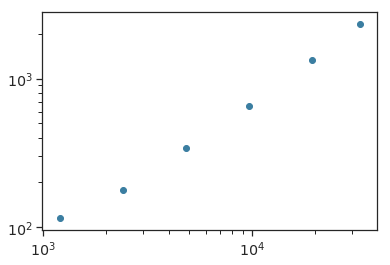

In [44]:
plt.loglog()
plt.scatter(cell_numbers, inference_times)
# plt.scatter(cell_numbers, inference_times_cpu);
# plt.ylim(bottom=5e0, top=1e4)
# plt.xlim(left=1e3, right=3e6)

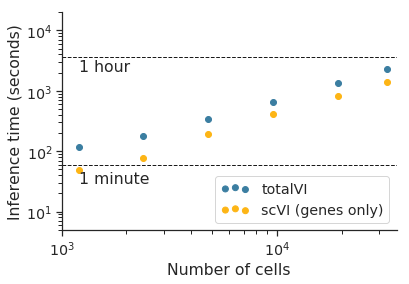

In [46]:
plt.loglog()

label_ = "totalVI"
plt.scatter(infer_time_df.cell_numbers, infer_time_df.totalVI_inference_time, label=label_)

label_ = "scVI (genes only)"
plt.scatter(infer_time_df.cell_numbers, infer_time_df.scVI_inference_time, label=label_)

plt.legend(scatterpoints=3, loc='lower right')

plt.xlabel('Number of cells')
plt.ylabel('Inference time (seconds)');
plt.axhline(60, lw=1, ls='--', c='k', zorder=-1);
plt.axhline(60 * 60, lw=1, ls='--', c='k', zorder=-1);

plt.annotate('1 hour', (1200, 2100));
plt.annotate('1 minute', (1200, 30));

plt.xlim(left=1000, right=36000)
plt.ylim(bottom=5e0, top=2e4);

sns.despine()
plt.savefig('figures/cells-v-time.pdf', bbox_inches="tight")